
<div style="display:fill;
           background-color:#ddc89caa;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
<img src="https://images.unsplash.com/photo-1460306855393-0410f61241c7?q=80&h=500&w=2000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D">
    
<H1 style="padding: 10px; color:black; font-weight:600;font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 42px;">Multi-Class Prediction of Obesity Risk</H1>
</div>


In [92]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("rocket")
# sns.color_palette("flare")
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostClassifier, cv
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, GaussianNoise 
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

<div style="background-color: #ddc89caa; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Table of Contents
    </h1>
</div>

<a href="#1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 1. Dataset Overview </a><br>
<a href="#2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 2. Data Processing </a> <br>
<a href="#3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 3. Exploratory Data Analysis & Visualization </a> <br>
<a href="#4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 4. Training Models </a><br>
<a href="#4.1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 16px;padding-left: 25px;"> 4.1 Baseline Modeling  </a><br>
<a href="#4.2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 16px;padding-left: 25px;"> 4.2 Ensembling XGB+LGBM+CAT using NN </a><br>
<a href="#7" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 5. Creating 'submission.csv' </a><br>


<div id="1" style="background-color: #ddc89caa; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
    Dataset Overview
    </h1>
</div>

In [93]:
orig_data = pd.read_csv("/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")
train_data = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv",index_col="id")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv",index_col="id")

train_data = pd.concat([orig_data,train_data])
train_data.reset_index(drop=True,inplace=True)
train_data.rename(columns={"family_history_with_overweight":"FamilyHistory"},inplace=True)
test_data.rename(columns={"family_history_with_overweight":"FamilyHistory"},inplace=True)

In [94]:
train_data.head(10)

,Gender,Age,Height,Weight,FamilyHistory,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


In [95]:
test_data.head(10)

,Gender,Age,Height,Weight,FamilyHistory,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation
20763,Male,19.799054,1.844751,59.605028,yes,yes,2.000000,4.000000,Sometimes,no,2.722063,no,2.000000,1.283673,no,Automobile
20764,Male,18.000000,1.728834,51.442293,yes,yes,1.202075,3.000000,Sometimes,no,1.087166,no,0.788585,1.000000,Sometimes,Public_Transportation
20765,Male,20.000000,1.810000,80.000000,yes,yes,2.000000,3.000000,Always,no,2.000000,no,3.000000,0.000000,no,Automobile
20766,Male,21.000000,1.700000,80.000000,yes,yes,2.000000,3.000000,Frequently,yes,2.000000,no,0.000000,2.000000,no,Public_Transportation


<div id="2" style="background-color: #ddc89caa; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
    Data Processing
    </h1>
</div>

In [96]:
train_data['BMI'] = train_data['Weight'] / (train_data['Height'] ** 2)
test_data['BMI'] = test_data['Weight'] / (test_data['Height'] ** 2)

In [97]:
le = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False,dtype="int64")
y_ohe = pd.DataFrame(ohe.fit_transform(train_data[["NObeyesdad"]]),columns = list(ohe.categories_[0])).values

for col in ["CAEC","MTRANS",'Gender', 'FamilyHistory', 'FAVC', 'SMOKE', 'SCC','CALC','NObeyesdad']:
    train_data[col] = le.fit_transform(train_data[col])
    if col!="NObeyesdad":
        test_data[col] = le.transform(test_data[col])
    print(f"> {col} Encoded")

> CAEC Encoded
> MTRANS Encoded
> Gender Encoded
> FamilyHistory Encoded
> FAVC Encoded
> SMOKE Encoded
> SCC Encoded
> CALC Encoded
> NObeyesdad Encoded


In [98]:
train_data.head()

,Gender,Age,Height,Weight,FamilyHistory,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1,24.386526
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1,24.238227
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1,23.765432
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5,26.851852
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6,28.342381


<div id="3" style="background-color: #ddc89caa; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
    Exploratory Data Analysis & Visualization 
    </h1>
</div>

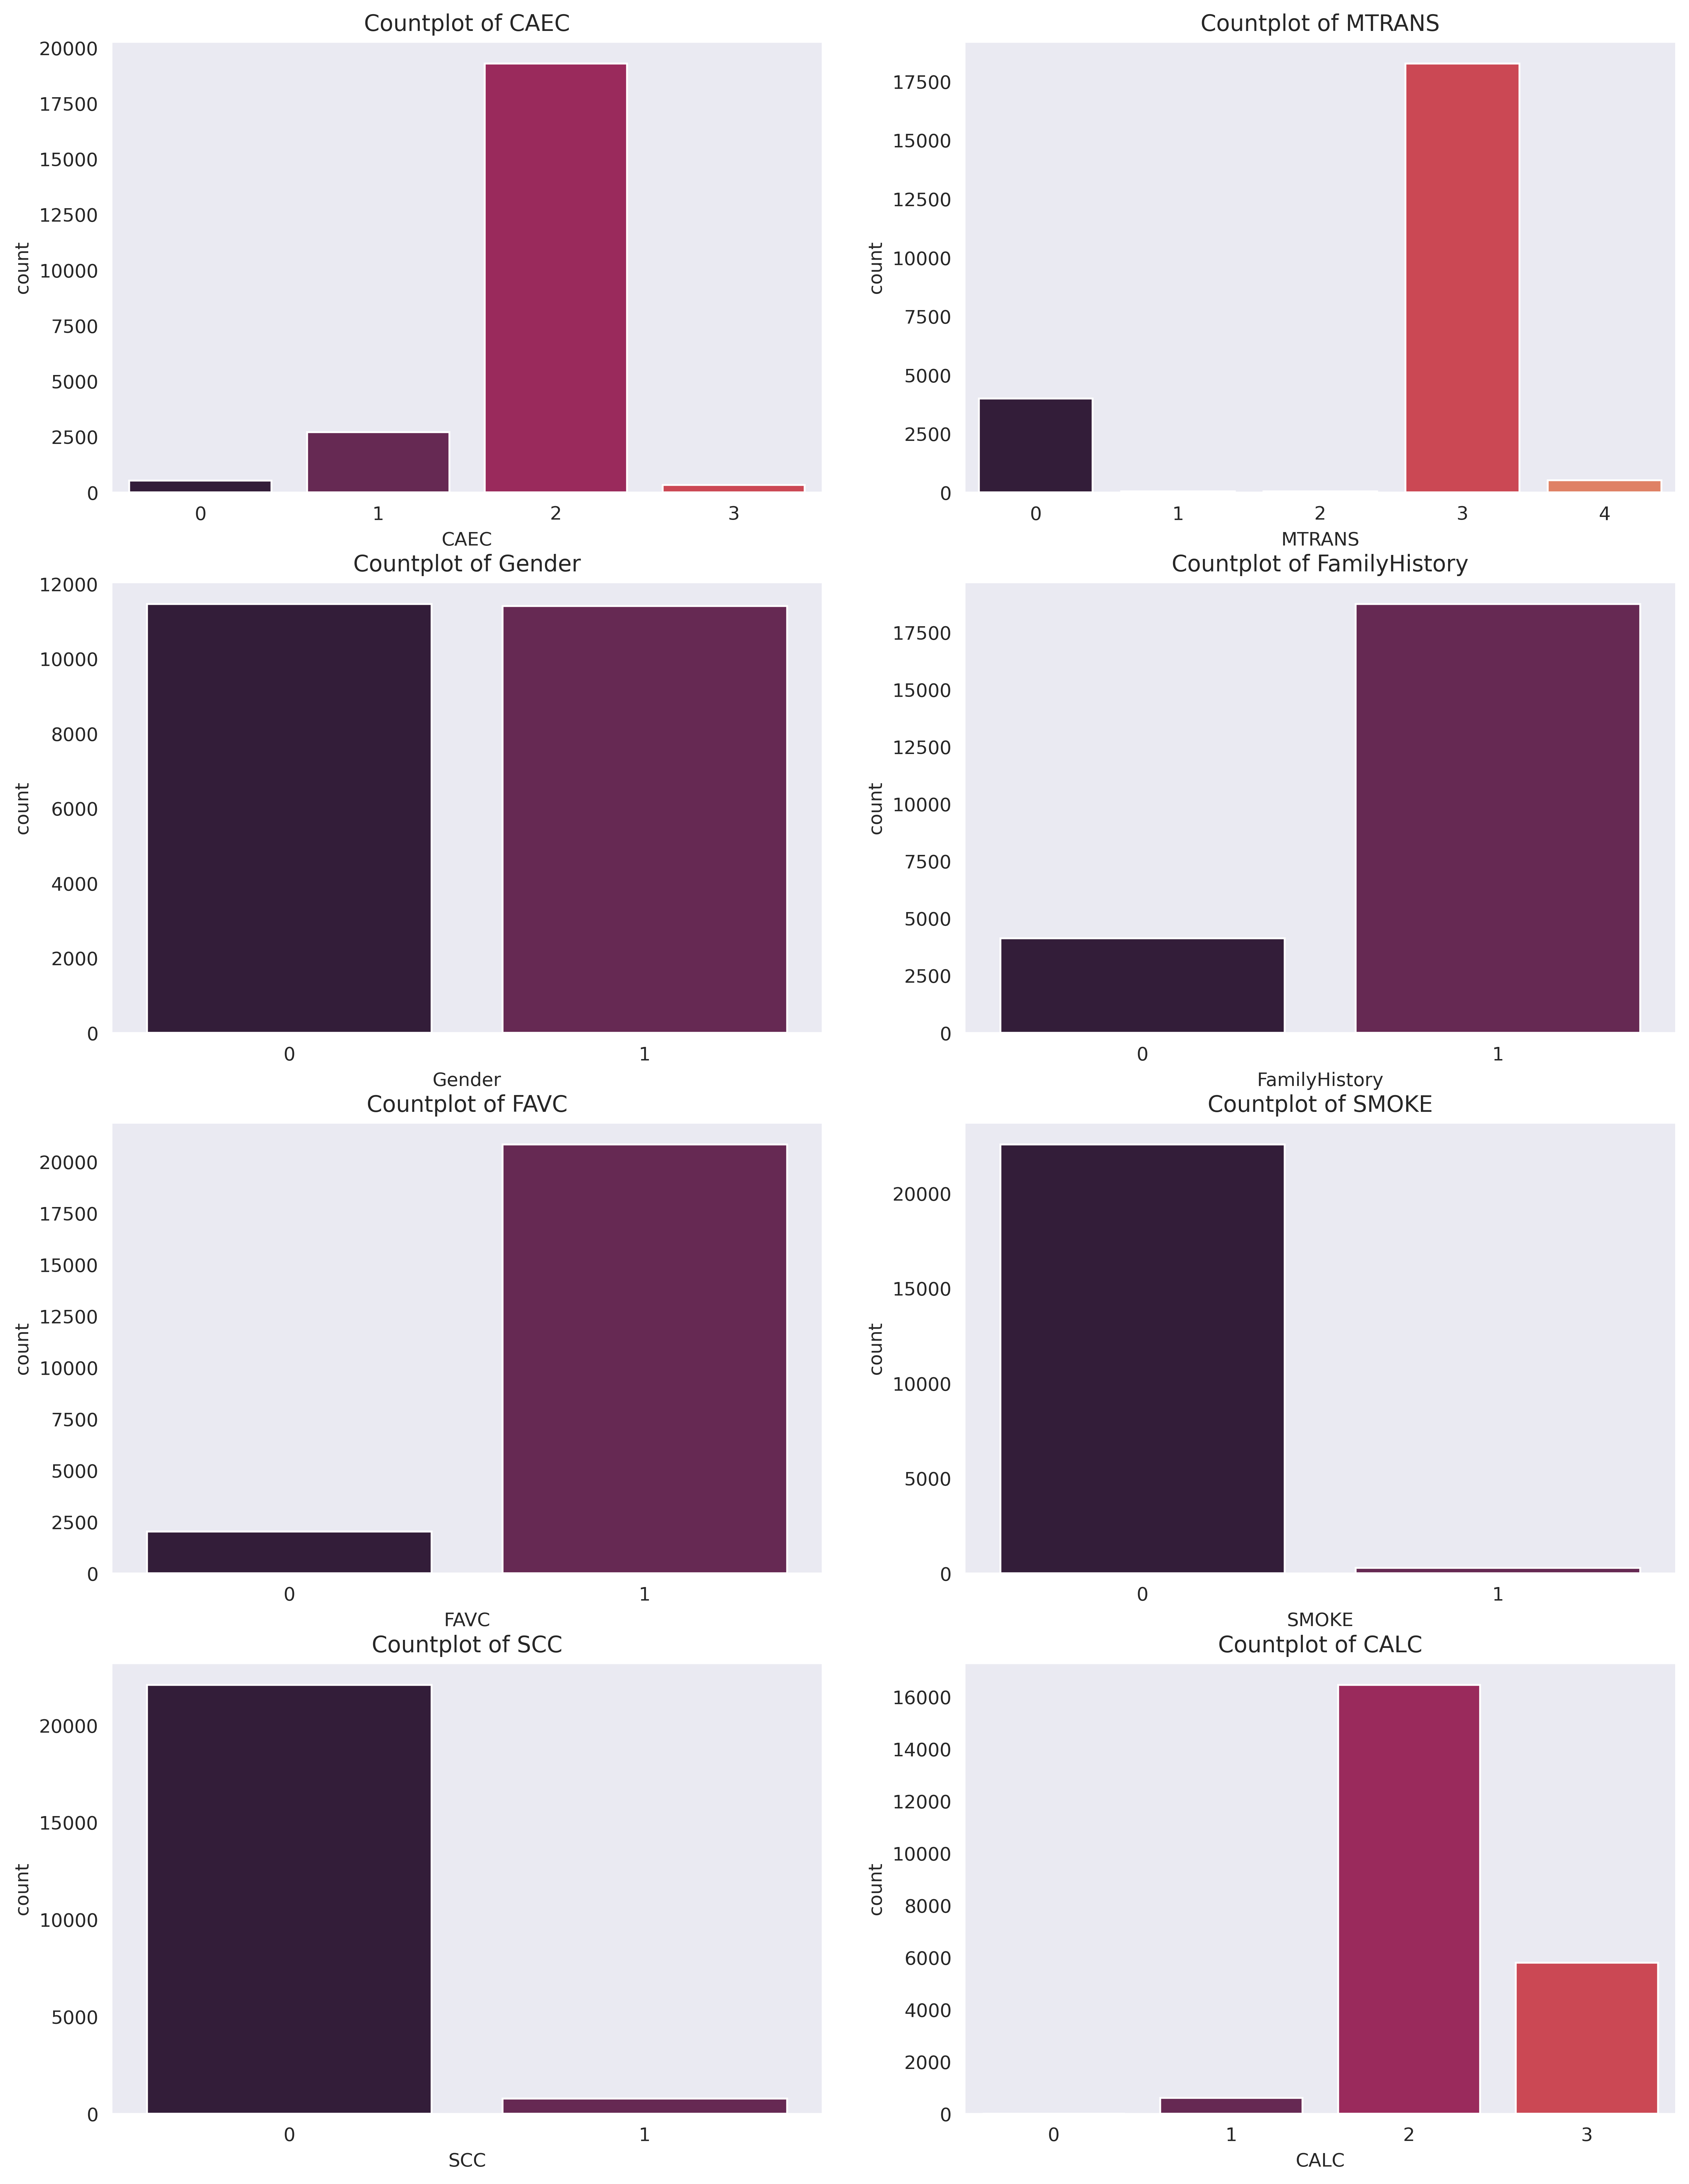

In [99]:
plt.subplots(4,2,figsize=(15,20),dpi=400)

for i,col in enumerate(["CAEC","MTRANS",'Gender', 'FamilyHistory', 'FAVC', 'SMOKE', 'SCC','CALC']):
    plt.subplot(4,2,i+1)
    sns.countplot(x=train_data[col])
    plt.title(f"Countplot of {col}")

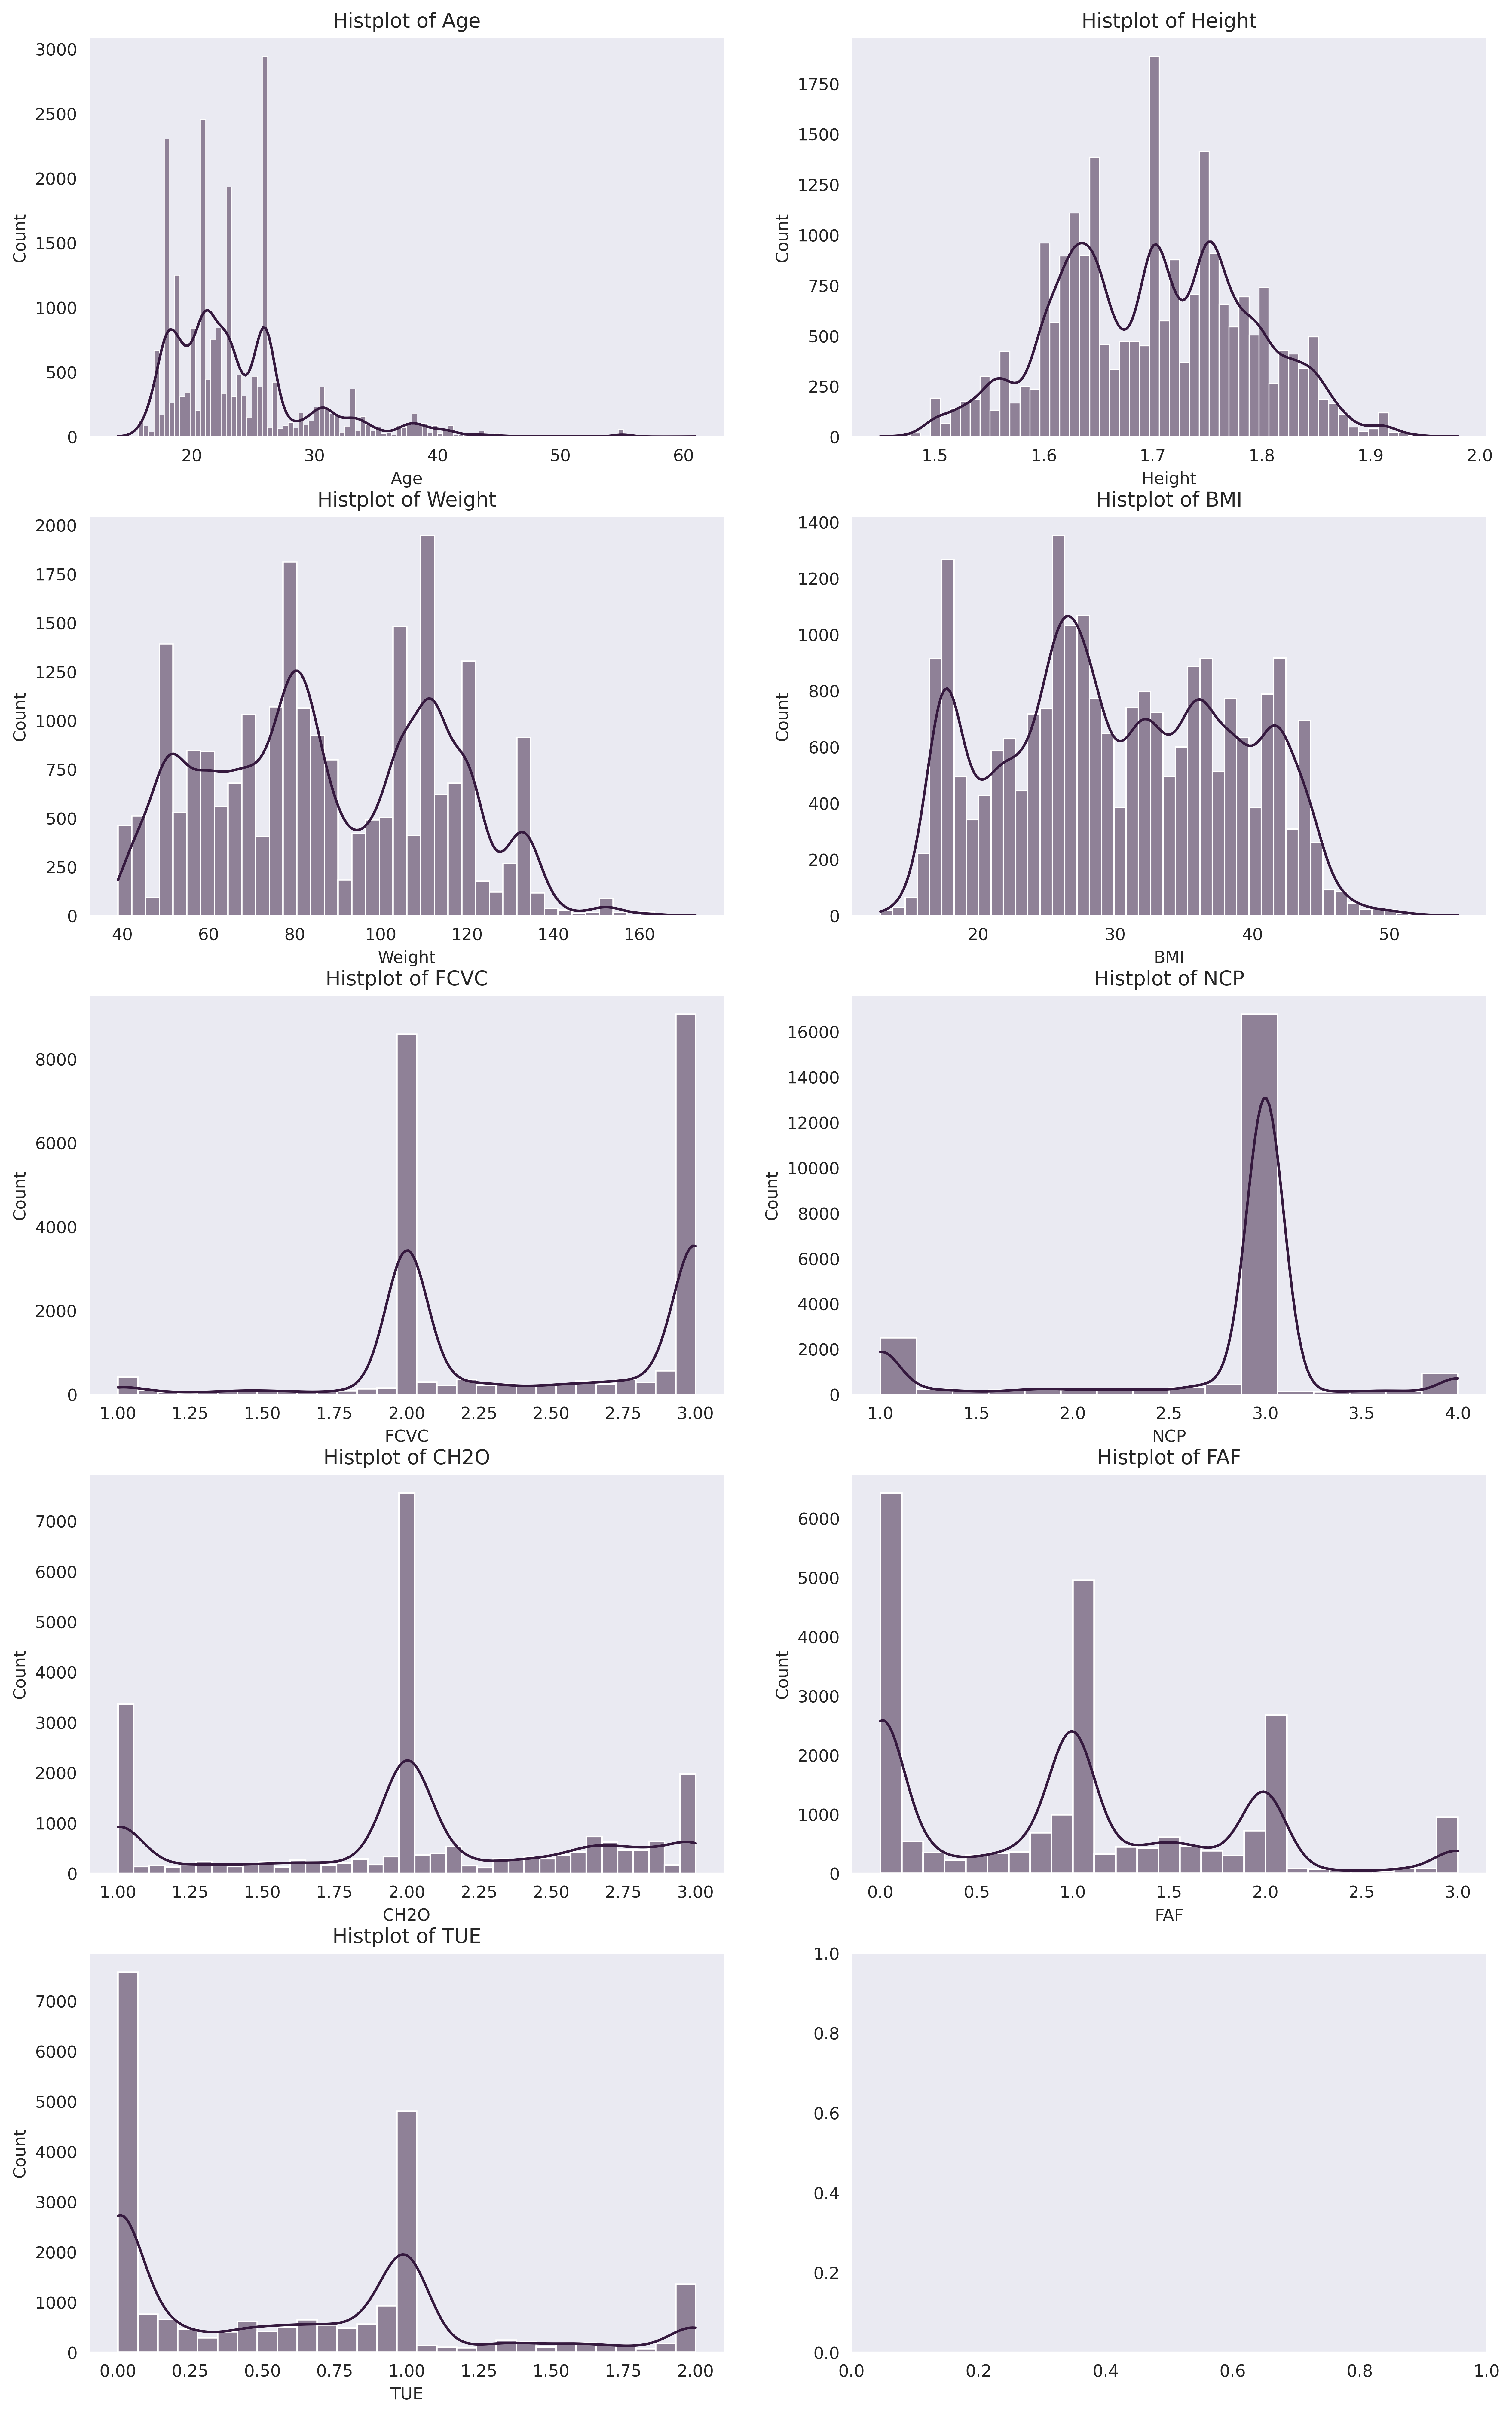

In [100]:
plt.subplots(5,2,figsize=(15,25),dpi=400)

for i,col in enumerate(['Age', 'Height', 'Weight', 'BMI', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']):
    plt.subplot(5,2,i+1)
    sns.histplot(x=train_data[col],kde=True)
    plt.title(f"Histplot of {col}")

<div id="4" style="background-color: #ddc89caa; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
   Training Models
    </h1>
</div>

In [101]:
seed = np.random.seed(6)

X = train_data.drop("NObeyesdad",axis=1)
y = train_data["NObeyesdad"]

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=seed)
print(len(X_train),len(X_val))

17151 5718


<div id="4.1" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.1 Baseline Models
    </h1>
</div>
<hr>

In [102]:
lgbmmodel = LGBMClassifier(random_state=seed,verbose=-1)
lgbmmodel.fit(X_train,y_train)
print("\n","-"*25,"Baseline LGBM","-"*25)
print("CV score of LGBM is ",cross_val_score(lgbmmodel,X,y,cv=4, scoring = 'accuracy').mean())
print("Accuracy over Val Data:",accuracy_score(lgbmmodel.predict(X_val),y_val))

xgbmodel = XGBClassifier(random_state=seed)
xgbmodel.fit(X_train,y_train)
print("\n","-"*25,"Baseline XGB","-"*25)
print("CV score of XGB is ",cross_val_score(xgbmodel,X,y,cv=4, scoring = 'accuracy').mean())
print("Accuracy over Val Data:",accuracy_score(xgbmodel.predict(X_val),y_val))

catmodel = CatBoostClassifier(random_state=seed,verbose=0)
catmodel.fit(X_train,y_train)
print("\n","-"*25,"Baseline CAT","-"*25)
print("CV score of Cat is ",cross_val_score(catmodel,X,y,cv=4, scoring = 'accuracy').mean())
print("Accuracy over Val Data:",accuracy_score(catmodel.predict(X_val),y_val))


 ------------------------- Baseline LGBM -------------------------
CV score of LGBM is  0.9109705790239317
Accuracy over Val Data: 0.9088842252535851

 ------------------------- Baseline XGB -------------------------
CV score of XGB is  0.9120201952253861
Accuracy over Val Data: 0.9081846799580273

 ------------------------- Baseline Cat -------------------------
CV score of Cat is  0.9113641267861914
Accuracy over Val Data: 0.909933543196922


In [103]:
lgbmPreds = pd.DataFrame(lgbmmodel.predict_proba(X))
xgbPreds = pd.DataFrame(xgbmodel.predict_proba(X))
catPreds = pd.DataFrame(catmodel.predict_proba(X))

feature_vector_train = pd.concat([xgbPreds,lgbmPreds,catPreds],axis=1).values

<div id="4.2" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.2 Ensembling XGB+LGBM+CAT using NN
    </h1>
</div>
<hr>

In [104]:
model = Sequential()
model.add(Dense(16, input_dim=21, activation="relu"))
model.add(Dense(32, activation=LeakyReLU(alpha=0.5)))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                352       
                                                                 
 dense_10 (Dense)            (None, 32)                544       
                                                                 
 dense_11 (Dense)            (None, 7)                 231       
                                                                 
Total params: 1127 (4.40 KB)
Trainable params: 1127 (4.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
modelCheckpoint = ModelCheckpoint('/kaggle/working/model/',save_best_only=True)
earlyStopping = EarlyStopping(monitor="val_loss",patience=20,start_from_epoch=5,restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=4, min_lr=0.00001)

In [106]:
history = model.fit(feature_vector_train,y_ohe,epochs=100,batch_size=128,validation_split=0.3,callbacks = [earlyStopping,reduceLR,modelCheckpoint])

Epoch 1/100
126/126 [==============================] - 2s 10ms/step - loss: 1.0994 - accuracy: 0.8246 - val_loss: 0.3144 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 2/100
126/126 [==============================] - 1s 8ms/step - loss: 0.1736 - accuracy: 0.9670 - val_loss: 0.1470 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 3/100
126/126 [==============================] - 1s 8ms/step - loss: 0.1258 - accuracy: 0.9673 - val_loss: 0.1368 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 4/100
126/126 [==============================] - 1s 8ms/step - loss: 0.1193 - accuracy: 0.9683 - val_loss: 0.1335 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 5/100
126/126 [==============================] - 1s 8ms/step - loss: 0.1167 - accuracy: 0.9686 - val_loss: 0.1304 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 6/100
126/126 [==============================] - 1s 8ms/step - loss: 0.1147 - accuracy: 0.9691 - val_loss: 0.1291 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 7/100
126/126 [==============================] - 0s 3ms/s

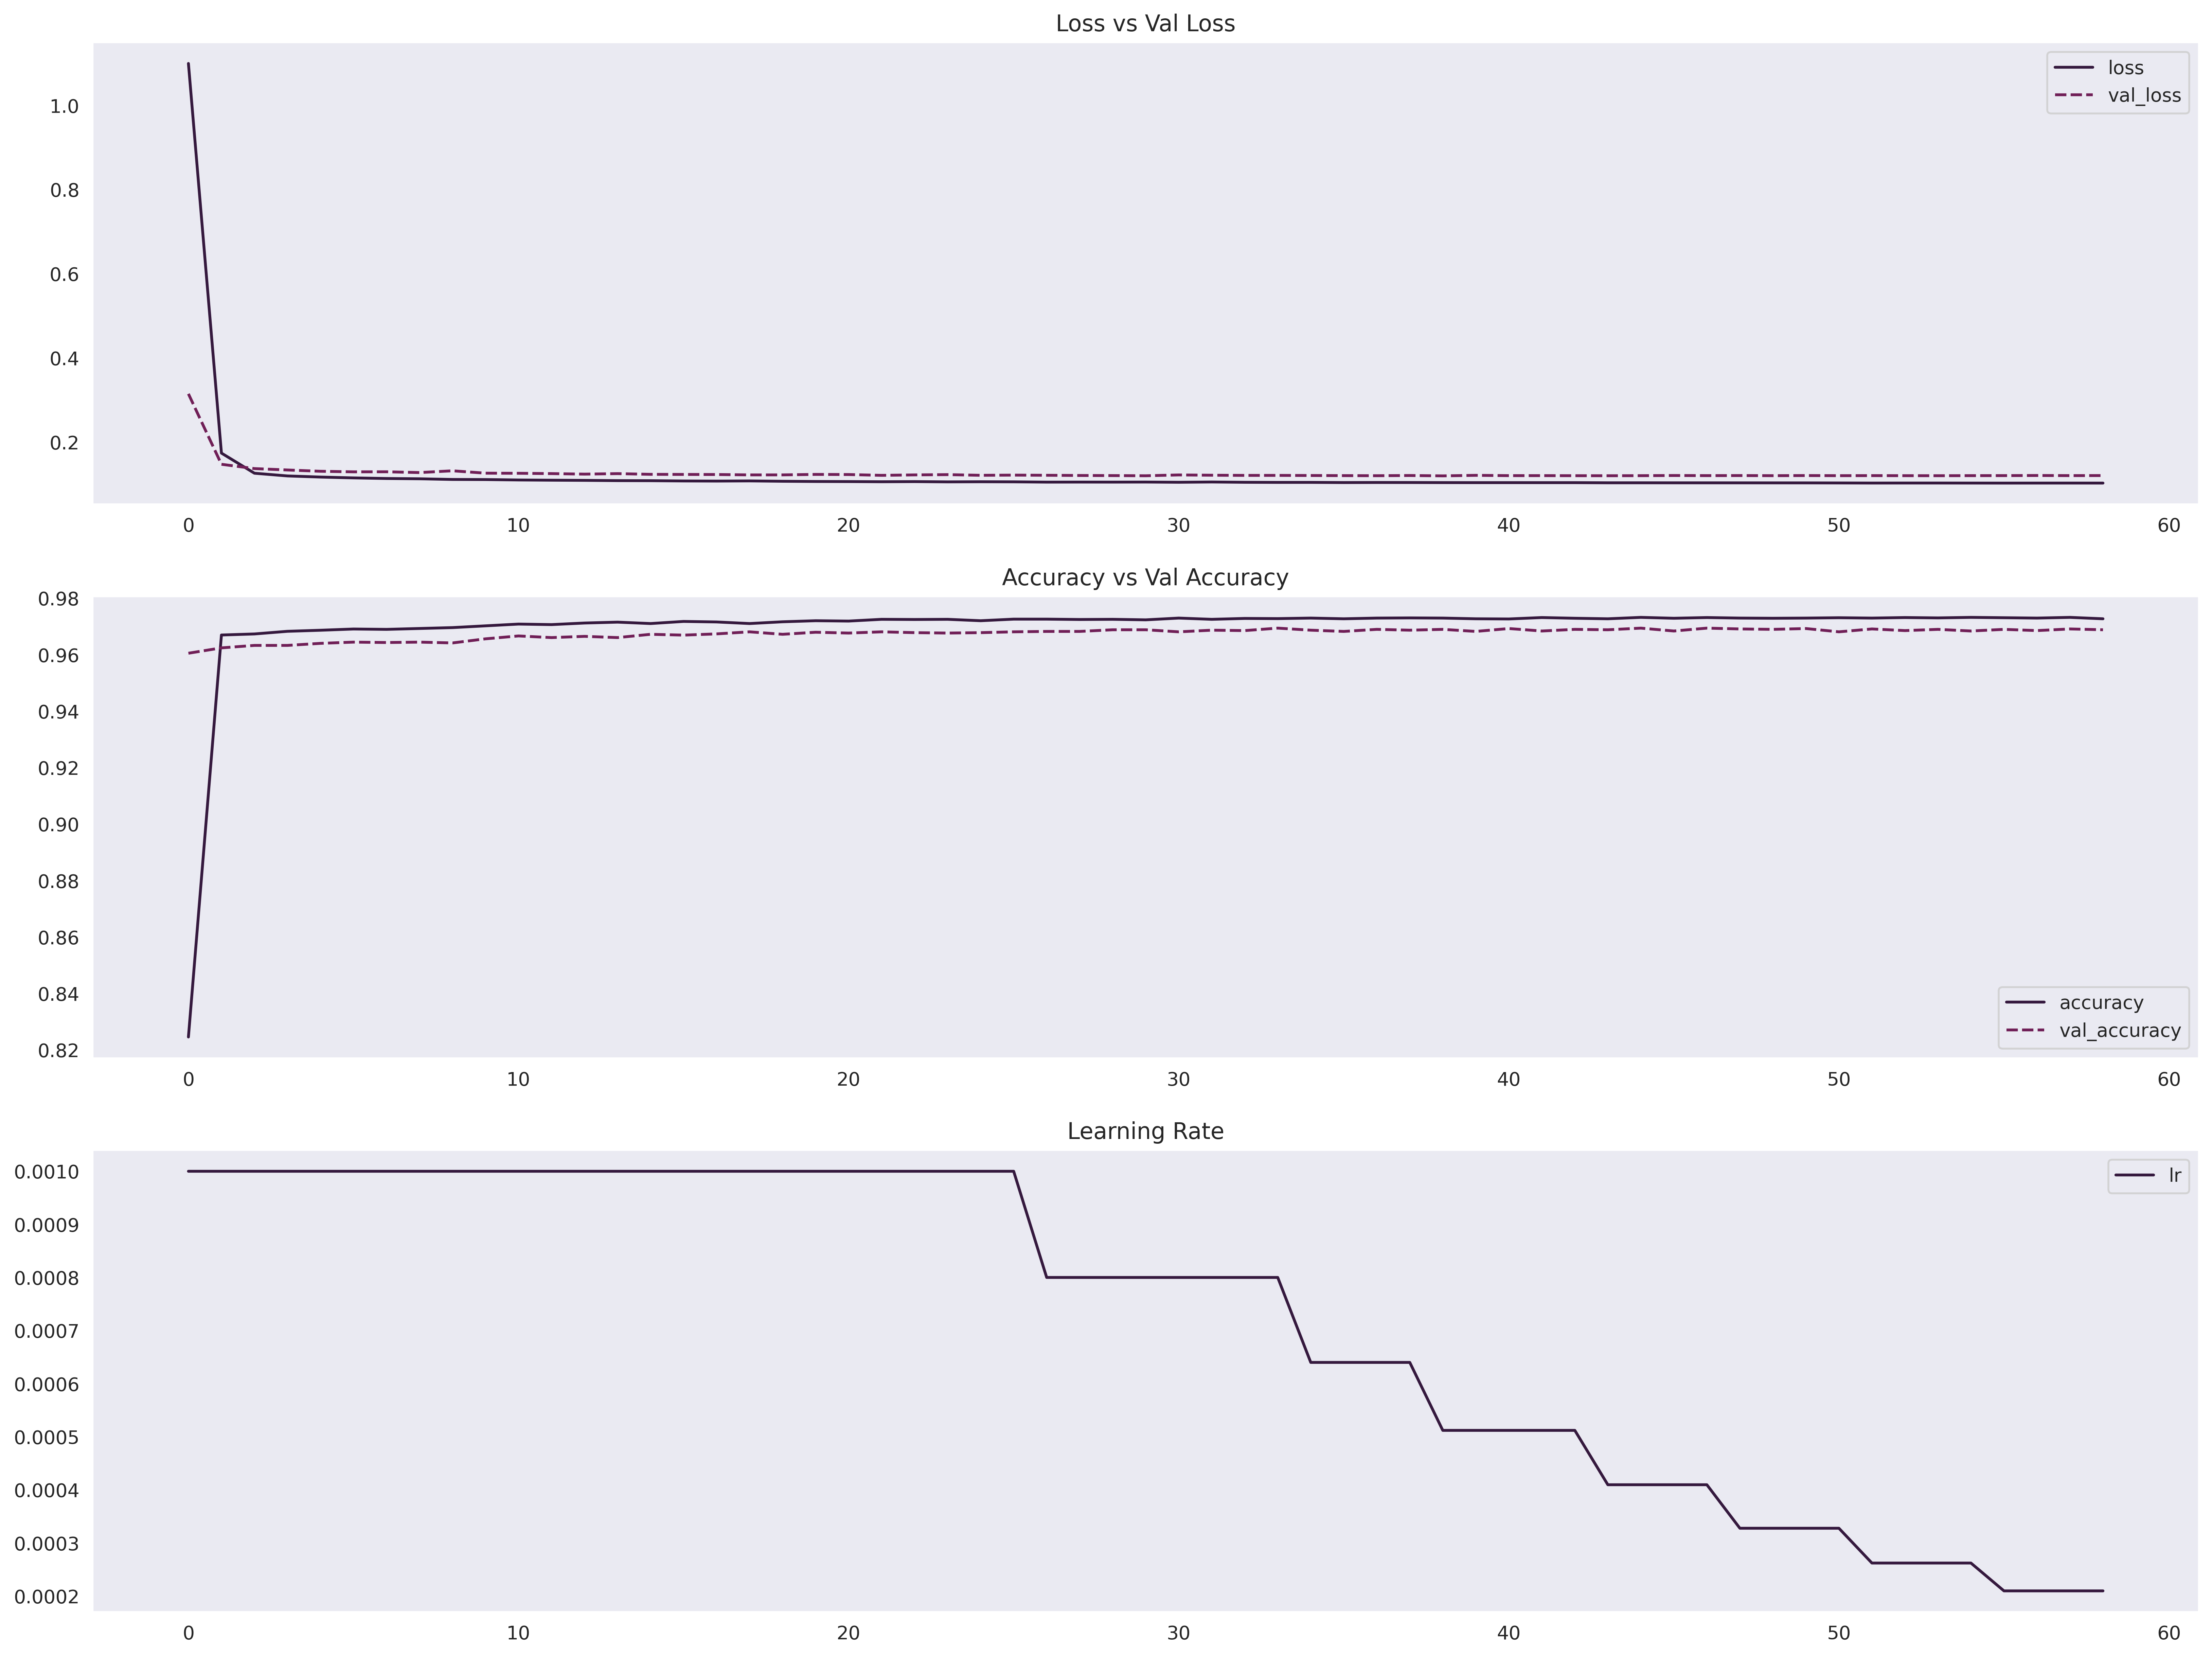

In [107]:
histPlot = pd.DataFrame(history.history)

plt.subplots(3,1,figsize=(20,15),dpi=400)

plt.subplot(3,1,1)
sns.lineplot(histPlot[["loss","val_loss"]])
plt.title("Loss vs Val Loss");
plt.subplot(3,1,2)
sns.lineplot(histPlot[["accuracy","val_accuracy"]])
plt.title("Accuracy vs Val Accuracy");
plt.subplot(3,1,3);
sns.lineplot(histPlot[["lr"]])
plt.title("Learning Rate");

<div id="7" style="background-color: #e1d9ce; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
   Creating 'submission.csv'
    </h1>
</div>

In [108]:
lgbmPreds = pd.DataFrame(lgbmmodel.predict_proba(test_data))
xgbPreds = pd.DataFrame(xgbmodel.predict_proba(test_data))
catPreds = pd.DataFrame(catmodel.predict_proba(test_data))

feature_vector_test = pd.concat([xgbPreds,lgbmPreds,catPreds],axis=1).values

In [109]:
preds = model.predict(feature_vector_test)
preds

433/433 [==============================] - 1s 1ms/step


array([[1.00063789e-05, 2.82491399e-08, 2.41696299e-03, ...,
        5.72083081e-06, 2.37528566e-05, 3.38365411e-04],
       [5.09906502e-04, 6.24187523e-03, 3.78614478e-03, ...,
        3.23560409e-04, 9.82379138e-01, 6.73303567e-03],
       [5.29538629e-05, 1.17642855e-07, 6.91285415e-04, ...,
        9.99203742e-01, 9.31190971e-06, 2.19982394e-06],
       ...,
       [9.90947068e-01, 6.24892768e-03, 3.35401419e-05, ...,
        4.60226409e-04, 2.17381865e-03, 9.81318735e-05],
       [6.05046842e-03, 9.85259712e-01, 5.61328307e-05, ...,
        4.28675958e-05, 7.41832284e-03, 1.16144051e-03],
       [9.97864299e-06, 2.80730017e-08, 2.40220223e-03, ...,
        5.70575185e-06, 2.36276155e-05, 3.36610188e-04]], dtype=float32)

In [110]:
ans = []
cols = ohe.categories_[0]
for i in range(len(test_data)):
    ans.append(cols[list(preds[i]).index(max(preds[i]))])

In [111]:
submission = test_data.copy()
submission["NObeyesdad"] = ans
submission[["NObeyesdad"]].head()

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III


In [112]:
submission[["NObeyesdad"]].to_csv("submission.csv",index=True,header=True)